# Tutorial
Spark's Python wrapper lets us interact with data very similarly to Pandas, which should be very familiar to Python users. In this notebook you will learn how to use the basic functionality of the wrapper, as well as visualize the data that you will be working with for the project. Make sure you have downloaded and unzipped the data to the correct location before trying to run the code.

In [52]:
# import necessary libraries
import pandas as pd 
import numpy
import matplotlib.pyplot as plt 
from pyspark.sql import SparkSession, dataframe
import plotly.express as px
geojson = px.data.gapminder()
# create sparksession
spark = SparkSession \
    .builder \
    .appName("CS236") \
    .getOrCreate()

In [45]:
# Utility function to write query plans to a file
# you will be using this to understand how your queries are being processed
def write_explain(df: dataframe.DataFrame, output_path: str = "out.txt"):
    from contextlib import redirect_stdout
    with open(output_path, "w") as f:
        with redirect_stdout(f):
            df.explain(extended=True)

Read a csv to a Spark dataframe, then return the column names

In [53]:
%%timeit
sdf = spark.read.csv("../data/StateAndCountyData.csv", header=True)

38.9 ms ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
sdf = spark.read.csv("../data/StateAndCountyData.csv", header=True)
sdf.columns

['FIPS', 'State', 'County', 'Variable_Code', 'Value']

Show the first 20 rows of the Spark dataframe

In [17]:
sdf.show()

+----+-----+-------+--------------------+------------+
|FIPS|State| County|       Variable_Code|       Value|
+----+-----+-------+--------------------+------------+
|1001|   AL|Autauga|       LACCESS_POP10| 18428.43969|
|1001|   AL|Autauga|       LACCESS_POP15| 17496.69304|
|1001|   AL|Autauga|PCH_LACCESS_POP_1...|-5.056025704|
|1001|   AL|Autauga|   PCT_LACCESS_POP10|  33.7696573|
|1001|   AL|Autauga|   PCT_LACCESS_POP15| 32.06225475|
|1001|   AL|Autauga|      LACCESS_LOWI10| 5344.427472|
|1001|   AL|Autauga|      LACCESS_LOWI15| 6543.676824|
|1001|   AL|Autauga|PCH_LACCESS_LOWI_...| 22.43924831|
|1001|   AL|Autauga|  PCT_LACCESS_LOWI10| 9.793530396|
|1001|   AL|Autauga|  PCT_LACCESS_LOWI15|   11.991125|
|1001|   AL|Autauga|      LACCESS_HHNV10| 664.2164872|
|1001|   AL|Autauga|      LACCESS_HHNV15| 677.6727692|
|1001|   AL|Autauga|PCH_LACCESS_HHNV_...| 2.025887979|
|1001|   AL|Autauga|  PCT_LACCESS_HHNV10| 3.284785556|
|1001|   AL|Autauga|  PCT_LACCESS_HHNV15| 3.351331631|
|1001|   A

In [54]:
sdf.createOrReplaceTempView('state_county')
# run your SQL query as you would with any database
my_df = spark.sql(
'''
select 
  state
  , avg(value) as avg
from state_county
where variable_code = 'PCT_LACCESS_POP15' 
group by state
order by state
'''
)
my_df.show()

+-----+------------------+
|state|               avg|
+-----+------------------+
|   AK|48.343788692862056|
|   AL|16.171105354880595|
|   AR|22.609819402973336|
|   AZ| 36.37027487666667|
|   CA|19.344139744189658|
|   CO|24.421295638984382|
|   CT|27.963876735000003|
|   DC|       2.108657988|
|   DE|17.489164766666665|
|   FL|23.765402494955225|
|   GA|16.965299157936716|
|   HI|      26.213889674|
|   IA|18.114561824040397|
|   ID|27.188629107318185|
|   IL| 19.56085678977228|
|   IN|14.825498790066662|
|   KS|31.835887066076186|
|   KY|11.375706728700852|
|   LA|   22.948595336875|
|   MA|25.146724972857147|
+-----+------------------+
only showing top 20 rows



In [55]:
write_explain(my_df)
# print out the query plan
my_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [state#107 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(state#107 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=6444]
      +- HashAggregate(keys=[state#107], functions=[avg(cast(value#110 as double))])
         +- Exchange hashpartitioning(state#107, 200), ENSURE_REQUIREMENTS, [plan_id=6441]
            +- HashAggregate(keys=[state#107], functions=[partial_avg(cast(value#110 as double))])
               +- Project [State#107, Value#110]
                  +- Filter (isnotnull(variable_code#109) AND (variable_code#109 = PCT_LACCESS_POP15))
                     +- FileScan csv [State#107,Variable_Code#109,Value#110] Batched: false, DataFilters: [isnotnull(Variable_Code#109), (Variable_Code#109 = PCT_LACCESS_POP15)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/home/jovyan/data/StateAndCountyData.csv], PartitionFilters: [], PushedFilters: [IsNotNull(Variable_Code), EqualTo(Variable_Code,PCT_LAC

## Visualizing with Choropleths
We will be using Plotly Express to easily visualize the data you will be working with. The most important arguments besides the dataframe itself are `locations` and `color`.
- `locations` - the name of the column that defines which values go into which state in the chart
- `color` - the name of the column that contains the values to be displayed

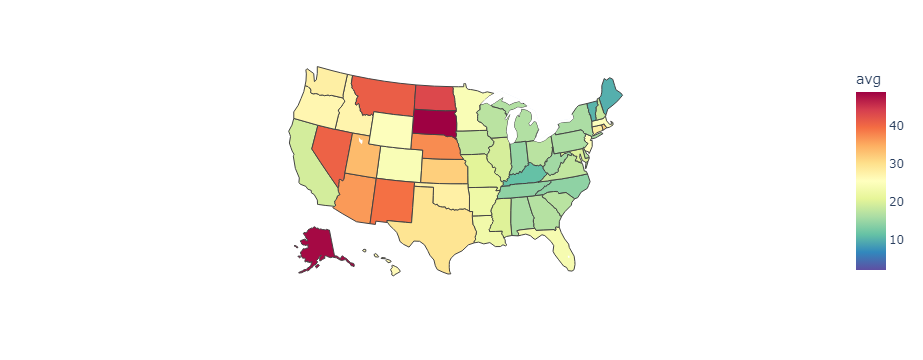

In [56]:
fig = px.choropleth(my_df,
                    locations='state',
                    color='avg',
                    color_continuous_scale='spectral_r',
                    locationmode='USA-states',
                    scope='usa')
fig.update_geos(
    visible=True, 
    scope="usa",
)
fig.show()